# Assignment 4

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
from zipfile import ZipFile
import PIL

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator

# date time to track model processing time
from datetime import datetime as dt

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions

In [ ]:
# Accuracy and loss Line plots visual
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [ ]:
# Shows Accuracy & Root Mean Square Error scores
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

In [ ]:
# Confusion Matrix visual
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Data Preperation

In [ ]:
# !unzip -u "/content/drive/My Drive/folder/example.zip" -d "/content/drive/My Drive/folder/NewFolder"
# !unzip -u '/content/drive/MyDrive/Colab Notebooks/ColabResearch/fruits-360-original-size.zip' -d '/content/drive/MyDrive/Colab Notebooks/ColabResearch/data/'

!unzip -u "/content/drive/My Drive/MSDS 458 - AI/Assignments/Assignment 4/fruits-360-original-size.zip" -d "/content/drive/My Drive/MSDS 458 - AI/Assignments/Assignment 4"

Archive:  /content/drive/My Drive/MSDS 458 - AI/Assignments/Assignment 4/fruits-360-original-size.zip


In [ ]:
train_dir = pathlib.Path('/content/drive/My Drive/MSDS 458 - AI/Assignments/Assignment 4/fruits-360-original-size/Training')
test_dir = pathlib.Path('/content/drive/My Drive/MSDS 458 - AI/Assignments/Assignment 4/fruits-360-original-size/Test')

In [ ]:
image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

6231

In [ ]:
fruits = list(train_dir.glob("Apple Pink Lady/*.jpg"))

In [ ]:
# for i in range(4):
#     plt.subplot(2, 2, i + 1)
#     img = PIL.Image.open(str(fruits[i]))
#     plt.imshow(img)
#     plt.axis('off')

# plt.show()

In [ ]:
batch_size = 128
img_height = 100
img_width = 100

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6231 files belonging to 24 classes.
Using 4985 files for training.


In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6231 files belonging to 24 classes.
Using 1246 files for validation.


In [ ]:
# x_preview, y_preview = get_three_classes(train_images, train_labels)
# x_preview, y_preview = get_three_classes(test_images, test_labels)

In [ ]:
class_names = train_data.class_names
num_classes = len(class_names)

# 24 classes
for i in class_names:
  print(f'Class: {i}')

Class: apple_6
Class: apple_braeburn_1
Class: apple_crimson_snow_1
Class: apple_golden_1
Class: apple_golden_2
Class: apple_golden_3
Class: apple_granny_smith_1
Class: apple_hit_1
Class: apple_pink_lady_1
Class: apple_red_1
Class: apple_red_2
Class: apple_red_3
Class: apple_red_delicios_1
Class: apple_red_yellow_1
Class: apple_rotten_1
Class: cabbage_white_1
Class: carrot_1
Class: cucumber_1
Class: cucumber_3
Class: eggplant_violet_1
Class: pear_1
Class: pear_3
Class: zucchini_1
Class: zucchini_dark_1


In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size = 128,
    class_mode='categorical'
)

Found 6231 images belonging to 24 classes.


In [ ]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height,img_width),
    batch_size = 128,
    class_mode='categorical'
)


Found 3110 images belonging to 24 classes.


In [ ]:
plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

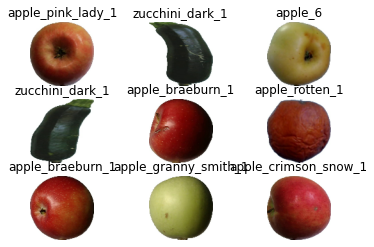

In [ ]:
#to take 1 batch
for images, labels in train_data.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Testing Model

In [ ]:
# # Example Model
# model = tf.keras.Sequential([
#     keras.Input(shape=(img_height, img_width, 3)),

#     keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
#     keras.layers.MaxPooling2D(2),
#     keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#     keras.layers.MaxPooling2D(2),
#      keras.layers.Dropout(0.5),

#     keras.layers.Flatten(),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(num_classes,  activation='softmax')
# ])

# model.summary()

In [ ]:
model_1 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_4 (Flatten)         (None, 40000)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               5120128   
                                                                 
 dense_9 (Dense)             (None, 24)                3096      
                                                      

## Compile the model

In [ ]:
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_1.fit(
  train_generator,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  epochs=10,
  verbose=1
)
end_time = dt.now()
print(f'Model_1 fit time: {end_time-start_time}')

Epoch 1/10
 9/15 [=================>............] - ETA: 4s - loss: 6.5384 - accuracy: 0.0693

KeyboardInterrupt: ignored

## Evaluation

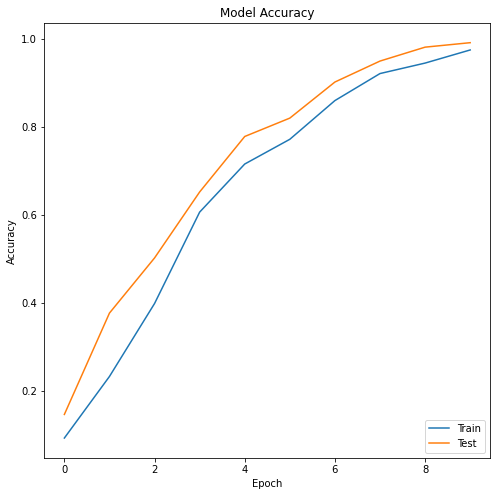

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

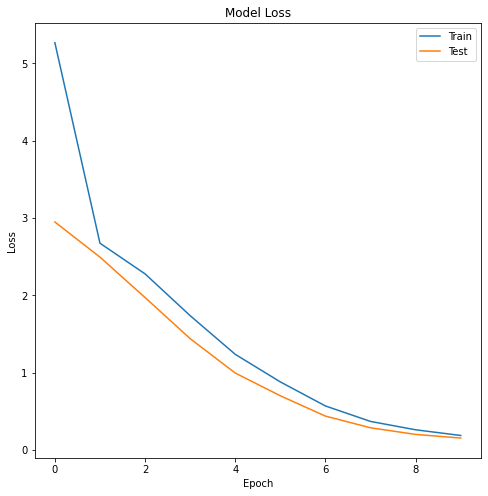

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_1.evaluate(test_generator)


25/25 [==============================] - 15s 614ms/step - loss: 0.1556 - accuracy: 0.9910


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.1555730402469635
Accuracy: 0.990996778011322


# Doesnt work


In [ ]:
pred1= model_1.predict(test_generator)
pred1=np.argmax(pred1, axis=1)

25/25 [==============================] - 15s 602ms/step


In [ ]:
pred1

array([10,  1, 14, ..., 13,  5, 21])

In [ ]:
print_validation_report(val_data, pred1)

Classification Report


ValueError: ignored

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df = pd.DataFrame(pred1[0:25], columns = [1,2])
df.style.format("{:.2%}").background_gradient(cmap=cm).T

ValueError: ignored

### TNSE

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(test_generator[:1])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

TypeError: ignored

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# Model_1: Baseline Model - 1 conv layer

In [ ]:
model_1 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 49, 49, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 38416)             0         
                                                                 
 dense_2 (Dense)             (None, 24)                922008    
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                      

## Compile the model

In [ ]:
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_1.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model1.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_1 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 38s 2s/step - loss: 0.2749 - accuracy: 0.9563 - val_loss: 0.2563 - val_accuracy: 0.9586
Epoch 2/200
15/15 [==============================] - 35s 2s/step - loss: 0.2484 - accuracy: 0.9583 - val_loss: 0.1898 - val_accuracy: 0.9734
Epoch 3/200
15/15 [==============================] - 32s 2s/step - loss: 0.2151 - accuracy: 0.9627 - val_loss: 0.1831 - val_accuracy: 0.9668
Epoch 4/200
15/15 [==============================] - 34s 2s/step - loss: 0.1852 - accuracy: 0.9719 - val_loss: 0.1508 - val_accuracy: 0.9746
Epoch 5/200
15/15 [==============================] - 31s 2s/step - loss: 0.1463 - accuracy: 0.9776 - val_loss: 0.1296 - val_accuracy: 0.9781
Epoch 6/200
15/15 [==============================] - 34s 2s/step - loss: 0.1449 - accuracy: 0.9776 - val_loss: 0.1134 - val_accuracy: 0.9867
Epoch 7/200
15/15 [==============================] - 32s 2s/step - loss: 0.1153 - accuracy: 0.9849 - val_loss: 0.0943 - val_accuracy: 0.9910
Epoch 8/200
1

## Evaluation

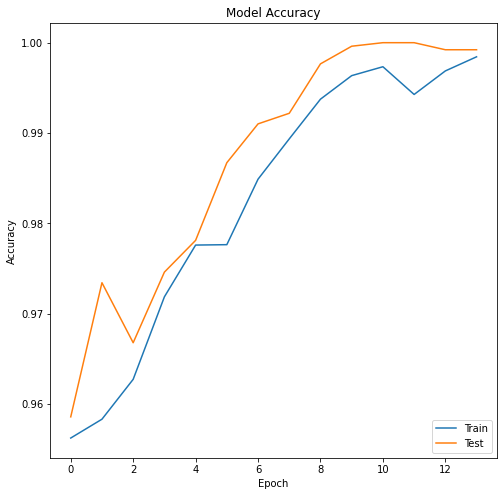

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

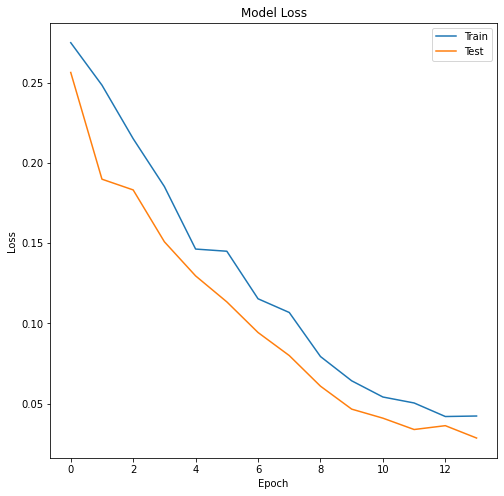

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_1.evaluate(test_generator)


25/25 [==============================] - 19s 770ms/step - loss: 0.0290 - accuracy: 0.9987


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.02904088981449604
Accuracy: 0.9987138509750366


# Model_2: Base Model with Padding

In [ ]:
model_2 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='same', activation='relu'), #padding same means padding is being applied
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_5 (Flatten)         (None, 40000)             0         
                                                                 
 dense_10 (Dense)            (None, 24)                960024    
                                                                 
 dense_11 (Dense)            (None, 24)                600       
                                                      

## Compile the model

In [ ]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_2.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_2.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_2 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 37s 2s/step - loss: 3.3239 - accuracy: 0.0469 - val_loss: 3.1761 - val_accuracy: 0.0512
Epoch 2/200
15/15 [==============================] - 32s 2s/step - loss: 3.1748 - accuracy: 0.0495 - val_loss: 3.1733 - val_accuracy: 0.0465
Epoch 3/200
15/15 [==============================] - 39s 3s/step - loss: 3.1714 - accuracy: 0.0719 - val_loss: 3.1703 - val_accuracy: 0.0781
Epoch 4/200
15/15 [==============================] - 36s 2s/step - loss: 3.1686 - accuracy: 0.0718 - val_loss: 3.1674 - val_accuracy: 0.0766
Epoch 5/200
15/15 [==============================] - 31s 2s/step - loss: 3.1669 - accuracy: 0.0750 - val_loss: 3.1647 - val_accuracy: 0.0785
Epoch 6/200
15/15 [==============================] - 31s 2s/step - loss: 3.1631 - accuracy: 0.0682 - val_loss: 3.1621 - val_accuracy: 0.0758
Epoch 7/200
15/15 [==============================] - 31s 2s/step - loss: 3.1602 - accuracy: 0.0818 - val_loss: 3.1597 - val_accuracy: 0.0719
Epoch 8/200
1

## Evaluation

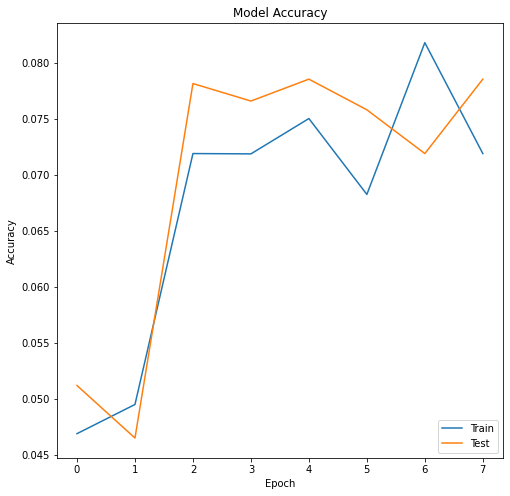

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

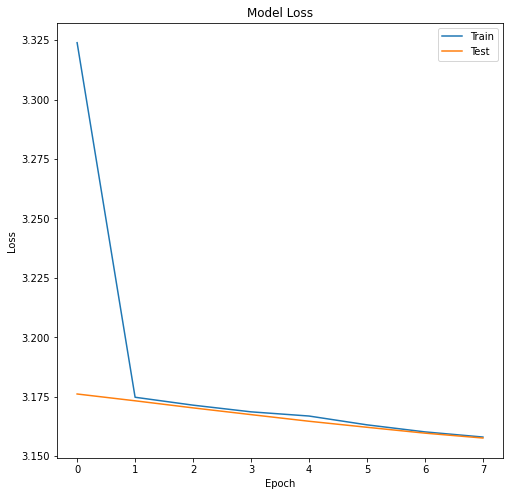

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_2.evaluate(test_generator)


25/25 [==============================] - 22s 860ms/step - loss: 3.1574 - accuracy: 0.0752


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 3.157386302947998
Accuracy: 0.07524115592241287


# Model_3: Baseline Model - Regularization

In [ ]:
model_3 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax',kernel_regularizer=tf.keras.regularizers.L2(0.001))
]) # L2 regularization

model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 49, 49, 16)        0         
                                                                 
 flatten_7 (Flatten)         (None, 38416)             0         
                                                                 
 dense_14 (Dense)            (None, 24)                922008    
                                                                 
 dense_15 (Dense)            (None, 24)                600       
                                                      

## Compile the model

In [ ]:
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_1.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_3.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_3 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 33s 2s/step - loss: 0.0389 - accuracy: 0.9969 - val_loss: 0.0303 - val_accuracy: 0.9996
Epoch 2/200
15/15 [==============================] - 31s 2s/step - loss: 0.0287 - accuracy: 0.9995 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 3/200
15/15 [==============================] - 32s 2s/step - loss: 0.0257 - accuracy: 0.9989 - val_loss: 0.0214 - val_accuracy: 0.9988
Epoch 4/200
15/15 [==============================] - 36s 2s/step - loss: 0.0229 - accuracy: 0.9995 - val_loss: 0.0171 - val_accuracy: 1.0000
Epoch 5/200
15/15 [==============================] - 31s 2s/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0149 - val_accuracy: 1.0000
Model_3 fit time: 0:02:58.210415


## Evaluation

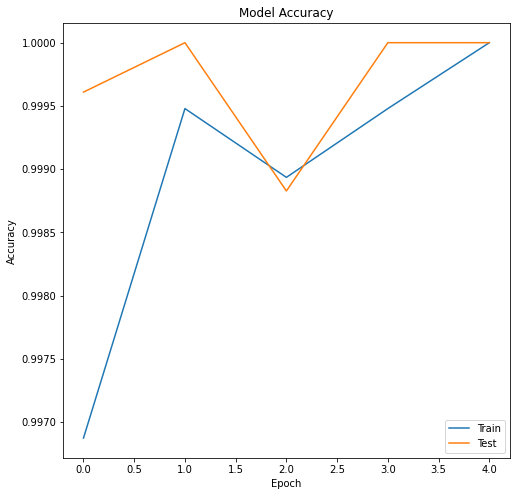

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

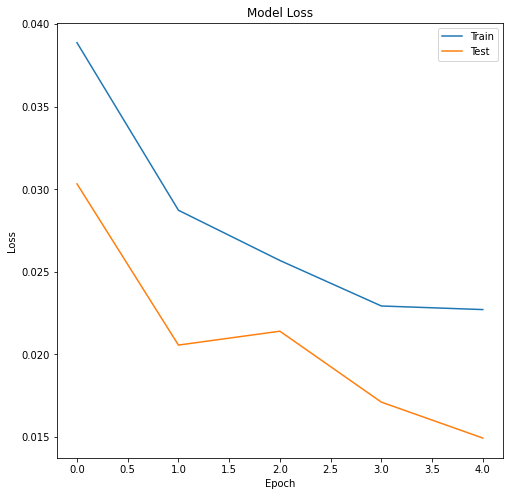

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_1.evaluate(test_generator)


25/25 [==============================] - 19s 753ms/step - loss: 0.0153 - accuracy: 1.0000


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.015334371477365494
Accuracy: 1.0


# Model_4: Baseline Model - Kernel_Size(5,5)

In [ ]:
model_4 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2), # Changed kernel size to 5,5
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 48, 48, 16)        0         
                                                                 
 flatten_9 (Flatten)         (None, 36864)             0         
                                                                 
 dense_18 (Dense)            (None, 24)                884760    
                                                                 
 dense_19 (Dense)            (None, 24)                600       
                                                      

## Compile the model

In [ ]:
model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_4.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_4.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_1 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 43s 3s/step - loss: 3.2725 - accuracy: 0.0495 - val_loss: 3.1237 - val_accuracy: 0.1187
Epoch 2/200
15/15 [==============================] - 36s 2s/step - loss: 3.0942 - accuracy: 0.1156 - val_loss: 3.0625 - val_accuracy: 0.0777
Epoch 3/200
15/15 [==============================] - 38s 3s/step - loss: 2.9908 - accuracy: 0.0854 - val_loss: 2.8959 - val_accuracy: 0.1008
Epoch 4/200
15/15 [==============================] - 35s 2s/step - loss: 2.7867 - accuracy: 0.1328 - val_loss: 2.6764 - val_accuracy: 0.1621
Epoch 5/200
15/15 [==============================] - 34s 2s/step - loss: 2.5885 - accuracy: 0.1767 - val_loss: 2.4922 - val_accuracy: 0.2539
Epoch 6/200
15/15 [==============================] - 40s 3s/step - loss: 2.4589 - accuracy: 0.2635 - val_loss: 2.3501 - val_accuracy: 0.3309
Epoch 7/200
15/15 [==============================] - 36s 2s/step - loss: 2.3409 - accuracy: 0.3198 - val_loss: 2.2483 - val_accuracy: 0.3531
Epoch 8/200
1

## Evaluation

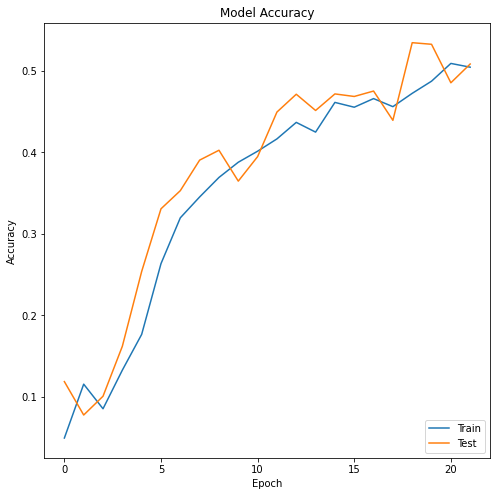

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

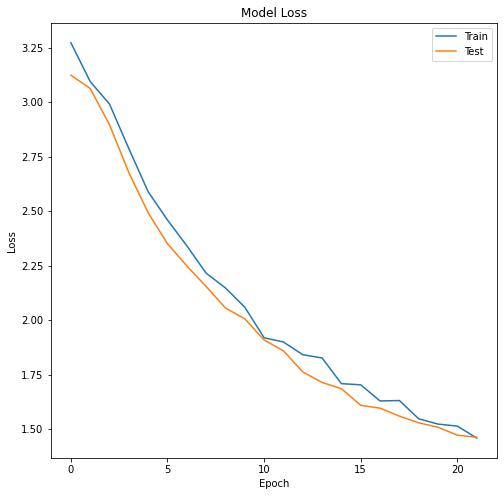

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_4.evaluate(test_generator)


25/25 [==============================] - 19s 763ms/step - loss: 1.4743 - accuracy: 0.5035


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 1.4742608070373535
Accuracy: 0.5035369992256165


# Model_5: Baseline Model - Stride Size 2,2

In [ ]:
model_5 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, strides=(2,2), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2), # changed strides from (1,1) to (2,2)
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 49, 49, 16)        448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 16)        0         
                                                                 
 flatten_10 (Flatten)        (None, 9216)              0         
                                                                 
 dense_20 (Dense)            (None, 24)                221208    
                                                                 
 dense_21 (Dense)            (None, 24)                600       
                                                     

## Compile the model

In [ ]:
model_5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_5.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_5.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_5 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 30s 2s/step - loss: 3.0725 - accuracy: 0.0922 - val_loss: 2.9659 - val_accuracy: 0.1027
Epoch 2/200
15/15 [==============================] - 27s 2s/step - loss: 2.8922 - accuracy: 0.1021 - val_loss: 2.7932 - val_accuracy: 0.1094
Epoch 3/200
15/15 [==============================] - 30s 2s/step - loss: 2.7043 - accuracy: 0.1219 - val_loss: 2.6249 - val_accuracy: 0.1668
Epoch 4/200
15/15 [==============================] - 28s 2s/step - loss: 2.5342 - accuracy: 0.1609 - val_loss: 2.4499 - val_accuracy: 0.1957
Epoch 5/200
15/15 [==============================] - 27s 2s/step - loss: 2.3809 - accuracy: 0.2016 - val_loss: 2.2419 - val_accuracy: 0.2594
Epoch 6/200
15/15 [==============================] - 26s 2s/step - loss: 2.1898 - accuracy: 0.2751 - val_loss: 2.0782 - val_accuracy: 0.3234
Epoch 7/200
15/15 [==============================] - 27s 2s/step - loss: 2.0599 - accuracy: 0.3214 - val_loss: 1.9324 - val_accuracy: 0.3656
Epoch 8/200
1

## Evaluation

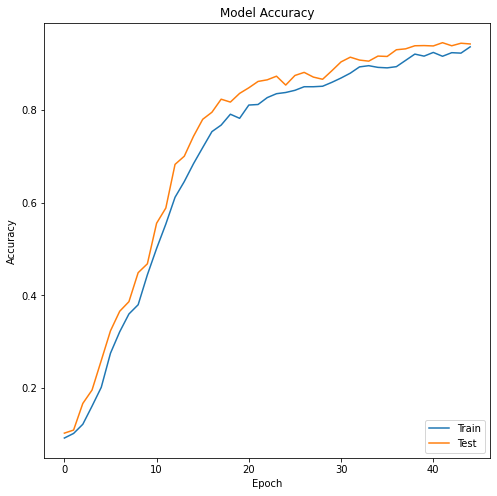

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

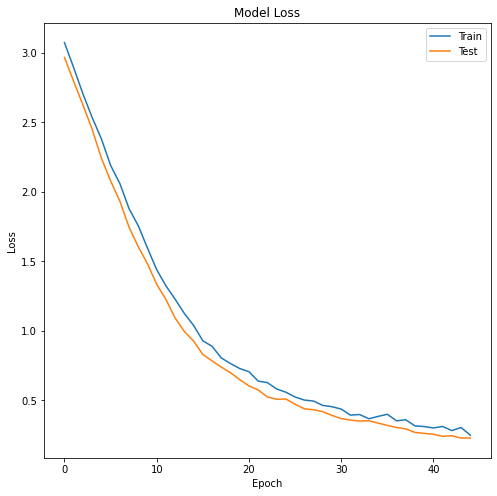

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_5.evaluate(test_generator)


25/25 [==============================] - 17s 664ms/step - loss: 0.2245 - accuracy: 0.9441


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.2245079129934311
Accuracy: 0.9440514445304871


# Model_6: Baseline Model - Dropout rate 0.3

In [ ]:
model_6 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.3), # changed dropout from 0.5 to 0.3

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 49, 49, 16)        448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 16)        0         
                                                                 
 flatten_10 (Flatten)        (None, 9216)              0         
                                                                 
 dense_20 (Dense)            (None, 24)                221208    
                                                                 
 dense_21 (Dense)            (None, 24)                600       
                                                     

## Compile the model

In [ ]:
model_6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_6.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_6.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_6 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 47s 3s/step - loss: 3.2423 - accuracy: 0.0639 - val_loss: 3.0822 - val_accuracy: 0.0629
Epoch 2/200
15/15 [==============================] - 34s 2s/step - loss: 3.0491 - accuracy: 0.0667 - val_loss: 2.9867 - val_accuracy: 0.0473
Epoch 3/200
15/15 [==============================] - 38s 3s/step - loss: 2.9517 - accuracy: 0.0677 - val_loss: 2.9015 - val_accuracy: 0.0586
Epoch 4/200
15/15 [==============================] - 32s 2s/step - loss: 2.8715 - accuracy: 0.0964 - val_loss: 2.7931 - val_accuracy: 0.1449
Epoch 5/200
15/15 [==============================] - 31s 2s/step - loss: 2.6949 - accuracy: 0.1506 - val_loss: 2.6318 - val_accuracy: 0.1648
Epoch 6/200
15/15 [==============================] - 34s 2s/step - loss: 2.5564 - accuracy: 0.1730 - val_loss: 2.4549 - val_accuracy: 0.1961
Epoch 7/200
15/15 [==============================] - 32s 2s/step - loss: 2.4201 - accuracy: 0.2167 - val_loss: 2.3680 - val_accuracy: 0.2336
Epoch 8/200
1

## Evaluation

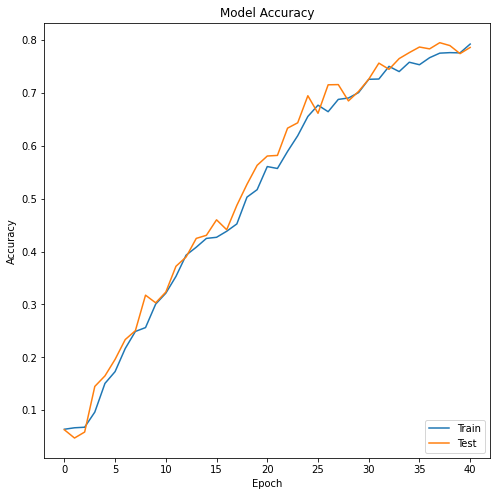

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

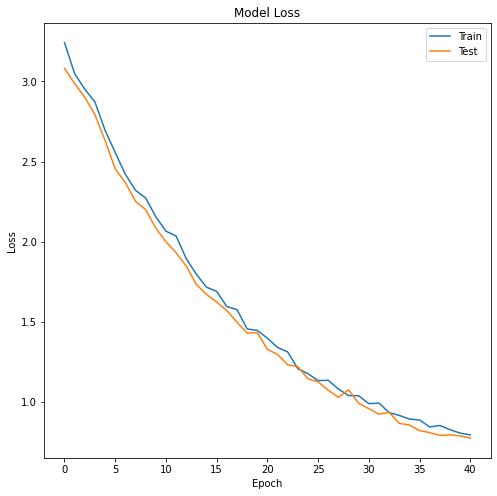

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_6.evaluate(test_generator)


25/25 [==============================] - 20s 780ms/step - loss: 0.7681 - accuracy: 0.7910


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.768139123916626
Accuracy: 0.790996789932251


# Model_7: Baseline Model - Batch Normalazation

In [ ]:
model_7 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    BatchNormalization(), # using Batch normalization
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 49, 49, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 38416)             0         
                                                                 
 dense_2 (Dense)             (None, 24)                922008    
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                      

## Compile the model

In [ ]:
model_7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_7.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_7.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_7 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 38s 3s/step - loss: 3.0521 - accuracy: 0.1151 - val_loss: 6.0247 - val_accuracy: 0.0750
Epoch 2/200
15/15 [==============================] - 34s 2s/step - loss: 2.5971 - accuracy: 0.2297 - val_loss: 6.4297 - val_accuracy: 0.0672
Epoch 3/200
15/15 [==============================] - 35s 2s/step - loss: 2.2904 - accuracy: 0.2969 - val_loss: 5.6586 - val_accuracy: 0.0918
Epoch 4/200
15/15 [==============================] - 35s 2s/step - loss: 1.9732 - accuracy: 0.3911 - val_loss: 4.9262 - val_accuracy: 0.0918
Epoch 5/200
15/15 [==============================] - 34s 2s/step - loss: 1.6005 - accuracy: 0.5052 - val_loss: 4.4790 - val_accuracy: 0.1348
Epoch 6/200
15/15 [==============================] - 32s 2s/step - loss: 1.1744 - accuracy: 0.5885 - val_loss: 3.8061 - val_accuracy: 0.2582
Epoch 7/200
15/15 [==============================] - 33s 2s/step - loss: 0.8547 - accuracy: 0.6770 - val_loss: 2.7835 - val_accuracy: 0.2770
Epoch 8/200
1

## Evaluation

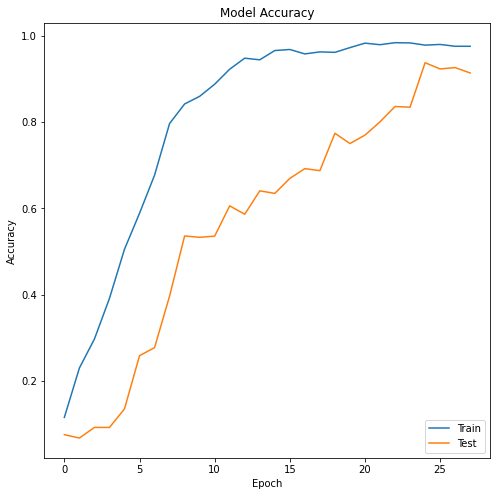

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

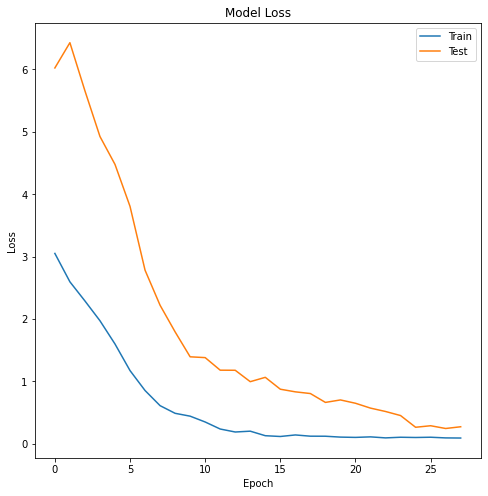

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_7.evaluate(test_generator)


25/25 [==============================] - 25s 1s/step - loss: 0.2762 - accuracy: 0.9129


In [ ]:

print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.2761516571044922
Accuracy: 0.9128617644309998


# Model_8: 1 conv layer All Changes

In [ ]:
model_8 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'), # padding
    keras.layers.MaxPooling2D(2), # kernel size and srides
     keras.layers.Dropout(0.3), # changed dropout rate

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    BatchNormalization(), # using Batch normalization
    keras.layers.Dense(num_classes,  activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.001)) # regularization
])

model_8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        1216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 24)                240024    
                                                                 
 batch_normalization_1 (Batc  (None, 24)               96        
 hNormalization)                                      

## Compile the model

In [ ]:
model_8.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_8.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model1.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_1 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 827s 57s/step - loss: 2.3443 - accuracy: 0.3740 - val_loss: 2.8483 - val_accuracy: 0.1703
Epoch 2/200
15/15 [==============================] - 303s 21s/step - loss: 1.5152 - accuracy: 0.7222 - val_loss: 2.5255 - val_accuracy: 0.4250
Epoch 3/200
15/15 [==============================] - 160s 11s/step - loss: 1.1219 - accuracy: 0.8792 - val_loss: 2.2286 - val_accuracy: 0.5188
Epoch 4/200
15/15 [==============================] - 122s 8s/step - loss: 0.8588 - accuracy: 0.9505 - val_loss: 1.9861 - val_accuracy: 0.6227
Epoch 5/200
15/15 [==============================] - 88s 6s/step - loss: 0.6814 - accuracy: 0.9787 - val_loss: 1.7333 - val_accuracy: 0.7773
Epoch 6/200
15/15 [==============================] - 69s 5s/step - loss: 0.5540 - accuracy: 0.9906 - val_loss: 1.5354 - val_accuracy: 0.8969
Epoch 7/200
15/15 [==============================] - 54s 4s/step - loss: 0.4708 - accuracy: 0.9891 - val_loss: 1.3545 - val_accuracy: 0.9945
Epoch 

## Evaluation

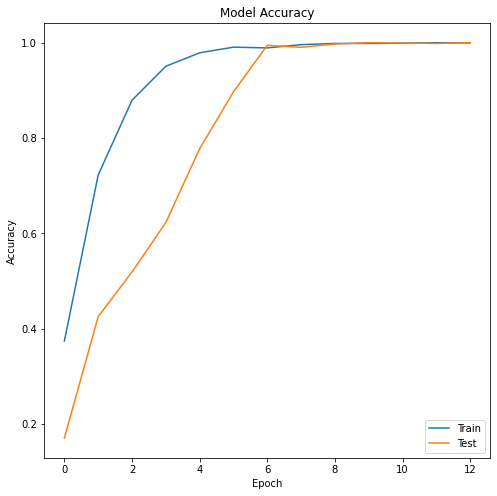

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

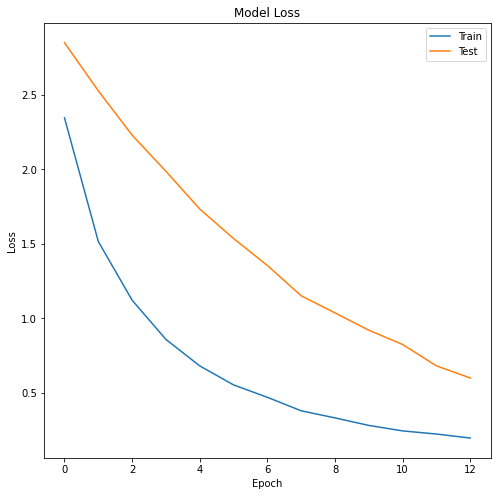

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_8.evaluate(test_generator)


25/25 [==============================] - 15s 584ms/step - loss: 0.6006 - accuracy: 1.0000


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.6006290316581726
Accuracy: 1.0


# Model_9: 2 conv layer of Basemodel

In [ ]:
model_9 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_9.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 flatten_14 (Flatten)        (None, 16928)           

## Compile the model

In [ ]:
model_9.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_9.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_9.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_9 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 39s 3s/step - loss: 2.8854 - accuracy: 0.1307 - val_loss: 2.3928 - val_accuracy: 0.3559
Epoch 2/200
15/15 [==============================] - 38s 2s/step - loss: 2.0604 - accuracy: 0.4172 - val_loss: 1.6358 - val_accuracy: 0.5168
Epoch 3/200
15/15 [==============================] - 36s 2s/step - loss: 1.3589 - accuracy: 0.6110 - val_loss: 1.0267 - val_accuracy: 0.7477
Epoch 4/200
15/15 [==============================] - 38s 3s/step - loss: 0.8793 - accuracy: 0.7609 - val_loss: 0.6453 - val_accuracy: 0.8297
Epoch 5/200
15/15 [==============================] - 35s 2s/step - loss: 0.5584 - accuracy: 0.8490 - val_loss: 0.3915 - val_accuracy: 0.9059
Epoch 6/200
15/15 [==============================] - 36s 2s/step - loss: 0.3859 - accuracy: 0.8922 - val_loss: 0.2617 - val_accuracy: 0.9430
Epoch 7/200
15/15 [==============================] - 34s 2s/step - loss: 0.2529 - accuracy: 0.9393 - val_loss: 0.1761 - val_accuracy: 0.9641
Epoch 8/200
1

## Evaluation

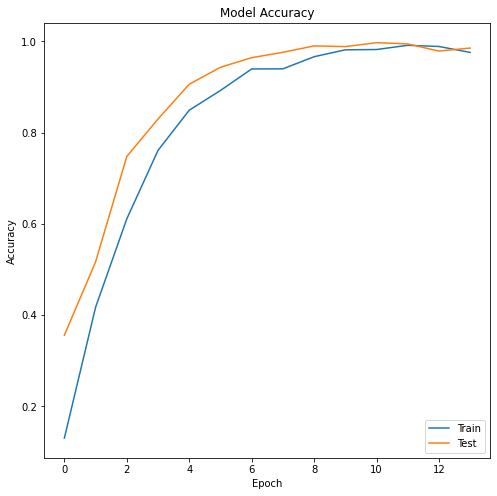

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

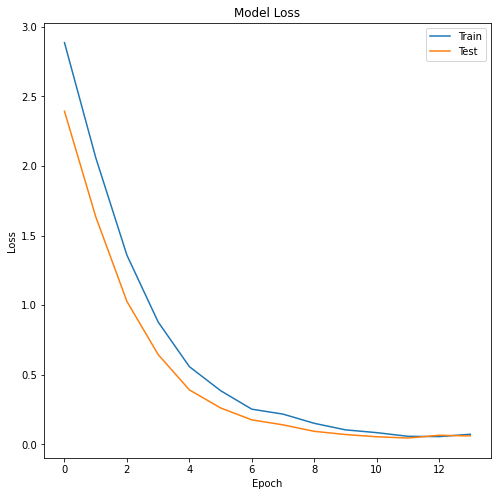

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_9.evaluate(test_generator)


25/25 [==============================] - 19s 724ms/step - loss: 0.0607 - accuracy: 0.9859


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.060695841908454895
Accuracy: 0.985852062702179


# Model_10: 2 conv layer with padding

In [ ]:
model_10 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='same', activation='relu'), # 'Same' activates padding
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'), # padding in each conv layer
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_10.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 25, 25, 32)        0         
                                                                 
 flatten_15 (Flatten)        (None, 20000)           

## Compile the model

In [ ]:
model_10.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_10.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_10.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_10 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 39s 3s/step - loss: 2.9860 - accuracy: 0.1086 - val_loss: 2.7591 - val_accuracy: 0.1309
Epoch 2/200
15/15 [==============================] - 34s 2s/step - loss: 2.6117 - accuracy: 0.2198 - val_loss: 2.3648 - val_accuracy: 0.3352
Epoch 3/200
15/15 [==============================] - 38s 3s/step - loss: 2.1955 - accuracy: 0.3302 - val_loss: 1.9590 - val_accuracy: 0.4309
Epoch 4/200
15/15 [==============================] - 36s 2s/step - loss: 1.7914 - accuracy: 0.4667 - val_loss: 1.5142 - val_accuracy: 0.5648
Epoch 5/200
15/15 [==============================] - 47s 3s/step - loss: 1.3935 - accuracy: 0.5792 - val_loss: 1.1275 - val_accuracy: 0.6734
Epoch 6/200
15/15 [==============================] - 40s 3s/step - loss: 1.0057 - accuracy: 0.6953 - val_loss: 0.9735 - val_accuracy: 0.7000
Epoch 7/200
15/15 [==============================] - 34s 2s/step - loss: 0.8374 - accuracy: 0.7521 - val_loss: 0.7217 - val_accuracy: 0.8035
Epoch 8/200
1

## Evaluation

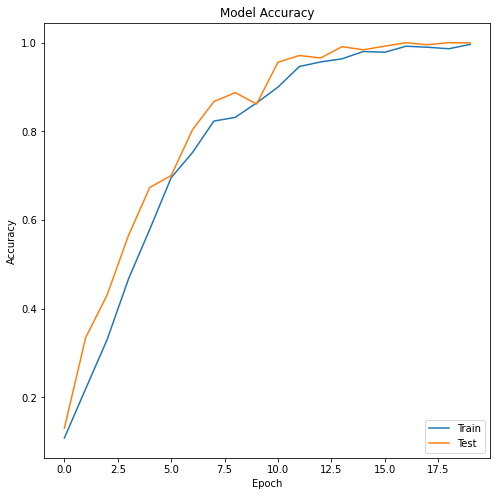

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

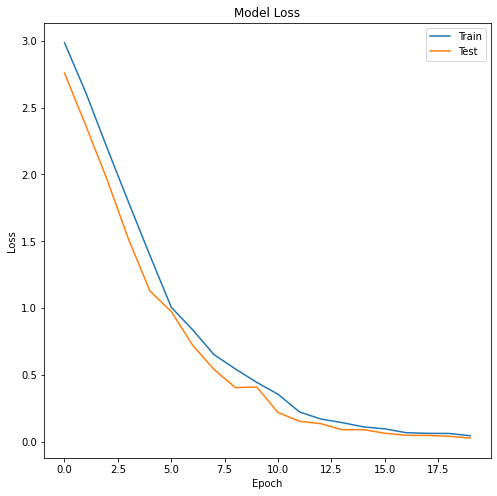

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_10.evaluate(test_generator)


25/25 [==============================] - 19s 770ms/step - loss: 0.0267 - accuracy: 0.9994


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.02667752467095852
Accuracy: 0.9993569254875183


# Model_11: 2 conv layer with Regularization

In [ ]:
model_11 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax',kernel_regularizer=tf.keras.regularizers.L2(0.001))
]) # using L2 regularization

model_11.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 flatten_18 (Flatten)        (None, 16928)           

## Compile the model

In [ ]:
model_11.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_11.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_11.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_11 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 36s 2s/step - loss: 2.9033 - accuracy: 0.1416 - val_loss: 2.4588 - val_accuracy: 0.2414
Epoch 2/200
15/15 [==============================] - 33s 2s/step - loss: 2.1996 - accuracy: 0.3057 - val_loss: 1.8242 - val_accuracy: 0.3914
Epoch 3/200
15/15 [==============================] - 33s 2s/step - loss: 1.5226 - accuracy: 0.4927 - val_loss: 1.1102 - val_accuracy: 0.6426
Epoch 4/200
15/15 [==============================] - 35s 2s/step - loss: 0.8864 - accuracy: 0.7312 - val_loss: 0.6237 - val_accuracy: 0.8602
Epoch 5/200
15/15 [==============================] - 35s 2s/step - loss: 0.5308 - accuracy: 0.8589 - val_loss: 0.3719 - val_accuracy: 0.9270
Epoch 6/200
15/15 [==============================] - 34s 2s/step - loss: 0.3349 - accuracy: 0.9266 - val_loss: 0.2188 - val_accuracy: 0.9688
Epoch 7/200
15/15 [==============================] - 38s 3s/step - loss: 0.2186 - accuracy: 0.9516 - val_loss: 0.1651 - val_accuracy: 0.9672
Epoch 8/200
1

## Evaluation

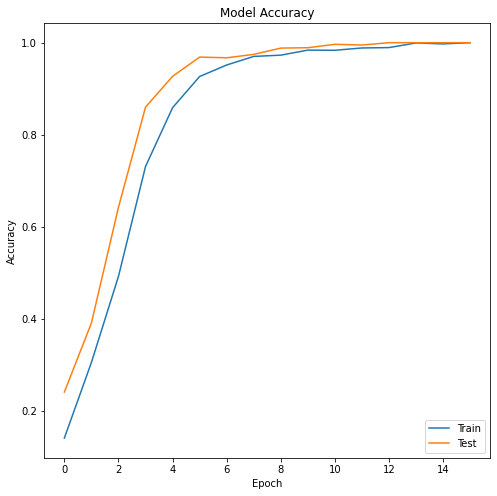

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

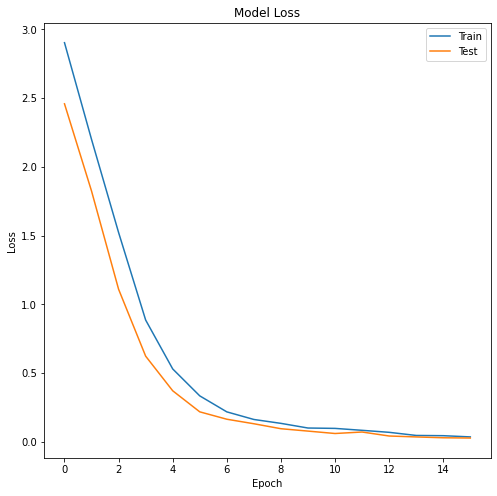

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_11.evaluate(test_generator)


25/25 [==============================] - 19s 736ms/step - loss: 0.0283 - accuracy: 1.0000


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.028265761211514473
Accuracy: 1.0


# Model_12: 2 conv layer with Kernel Size (5,5)

In [ ]:
model_12 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2), # increased kernel size to (5,5)
    keras.layers.Conv2D(32, kernel_size=(5, 5),strides=(1, 1), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_12.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 32)        12832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 15488)            

## Compile the model

In [ ]:
model_12.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_12.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_12.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_12 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 152s 10s/step - loss: 3.0015 - accuracy: 0.0760 - val_loss: 2.7175 - val_accuracy: 0.1691
Epoch 2/200
15/15 [==============================] - 122s 8s/step - loss: 2.5143 - accuracy: 0.2528 - val_loss: 2.2484 - val_accuracy: 0.2801
Epoch 3/200
15/15 [==============================] - 113s 8s/step - loss: 2.0583 - accuracy: 0.3469 - val_loss: 1.7847 - val_accuracy: 0.4105
Epoch 4/200
15/15 [==============================] - 84s 6s/step - loss: 1.6541 - accuracy: 0.4481 - val_loss: 1.3677 - val_accuracy: 0.5711
Epoch 5/200
15/15 [==============================] - 73s 5s/step - loss: 1.2486 - accuracy: 0.5828 - val_loss: 0.9948 - val_accuracy: 0.6789
Epoch 6/200
15/15 [==============================] - 66s 4s/step - loss: 0.9170 - accuracy: 0.7036 - val_loss: 0.6866 - val_accuracy: 0.8102
Epoch 7/200
15/15 [==============================] - 85s 6s/step - loss: 0.5760 - accuracy: 0.8292 - val_loss: 0.4798 - val_accuracy: 0.8520
Epoch 8/2

## Evaluation

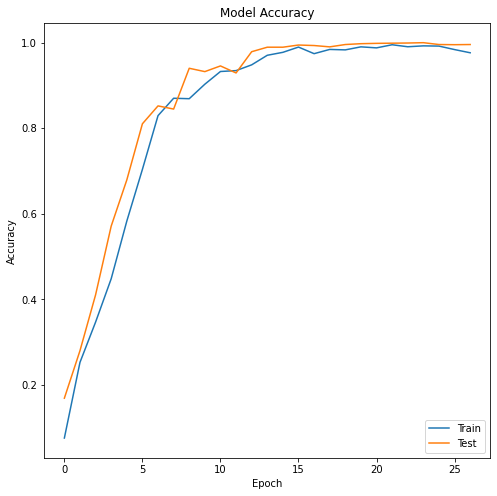

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

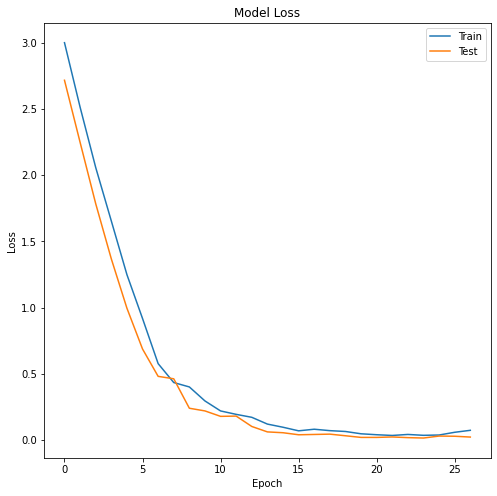

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_12.evaluate(test_generator)


25/25 [==============================] - 29s 1s/step - loss: 0.0214 - accuracy: 0.9952


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.02143861912190914
Accuracy: 0.9951768517494202


# Model_13: 2 conv layer with Stride size 2,2

In [ ]:
model_13 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, strides=(2,2),padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2), # increased stride to (2,2)
    keras.layers.Conv2D(32, 3,strides=(2,2), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_13.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 49, 49, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 flatten_2 (Flatten)         (None, 800)              

## Compile the model

In [ ]:
model_13.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_13.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_13.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_13 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 36s 2s/step - loss: 3.1487 - accuracy: 0.0719 - val_loss: 3.0588 - val_accuracy: 0.1789
Epoch 2/200
15/15 [==============================] - 35s 2s/step - loss: 2.9648 - accuracy: 0.1234 - val_loss: 2.7799 - val_accuracy: 0.2160
Epoch 3/200
15/15 [==============================] - 35s 2s/step - loss: 2.6380 - accuracy: 0.1937 - val_loss: 2.3336 - val_accuracy: 0.2762
Epoch 4/200
15/15 [==============================] - 33s 2s/step - loss: 2.2395 - accuracy: 0.2755 - val_loss: 1.8614 - val_accuracy: 0.5074
Epoch 5/200
15/15 [==============================] - 36s 2s/step - loss: 1.7996 - accuracy: 0.4343 - val_loss: 1.4096 - val_accuracy: 0.6469
Epoch 6/200
15/15 [==============================] - 34s 2s/step - loss: 1.4286 - accuracy: 0.5370 - val_loss: 1.1209 - val_accuracy: 0.6707
Epoch 7/200
15/15 [==============================] - 34s 2s/step - loss: 1.1910 - accuracy: 0.6068 - val_loss: 0.8457 - val_accuracy: 0.7676
Epoch 8/200
1

## Evaluation

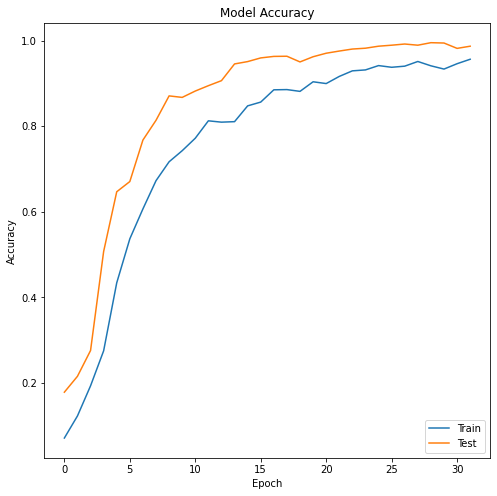

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

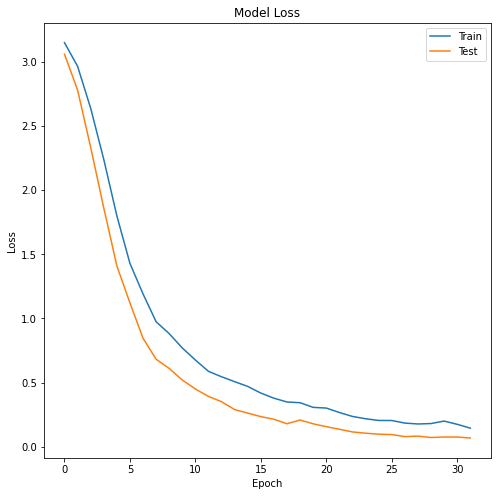

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_13.evaluate(test_generator)


25/25 [==============================] - 23s 902ms/step - loss: 0.0673 - accuracy: 0.9878


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.06733524799346924
Accuracy: 0.9877813458442688


# Model_14: 2 conv layer with dropout rate = 0.3

In [ ]:
model_14 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.3), # lowered dropout rate to 0.3

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_14.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 16928)            

## Compile the model

In [ ]:
model_14.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_14.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_14.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_14 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 51s 3s/step - loss: 2.8245 - accuracy: 0.1573 - val_loss: 2.5426 - val_accuracy: 0.2598
Epoch 2/200
15/15 [==============================] - 49s 3s/step - loss: 2.1610 - accuracy: 0.3438 - val_loss: 1.7244 - val_accuracy: 0.4941
Epoch 3/200
15/15 [==============================] - 64s 4s/step - loss: 1.3764 - accuracy: 0.5780 - val_loss: 1.0316 - val_accuracy: 0.7012
Epoch 4/200
15/15 [==============================] - 48s 3s/step - loss: 0.8214 - accuracy: 0.7437 - val_loss: 0.6178 - val_accuracy: 0.7738
Epoch 5/200
15/15 [==============================] - 51s 4s/step - loss: 0.5118 - accuracy: 0.8474 - val_loss: 0.3489 - val_accuracy: 0.9227
Epoch 6/200
15/15 [==============================] - 45s 3s/step - loss: 0.3003 - accuracy: 0.9202 - val_loss: 0.2340 - val_accuracy: 0.9504
Epoch 7/200
15/15 [==============================] - 47s 3s/step - loss: 0.2241 - accuracy: 0.9448 - val_loss: 0.1823 - val_accuracy: 0.9559
Epoch 8/200
1

## Evaluation

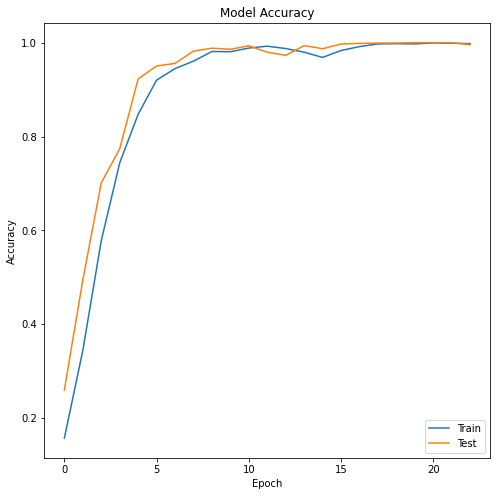

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

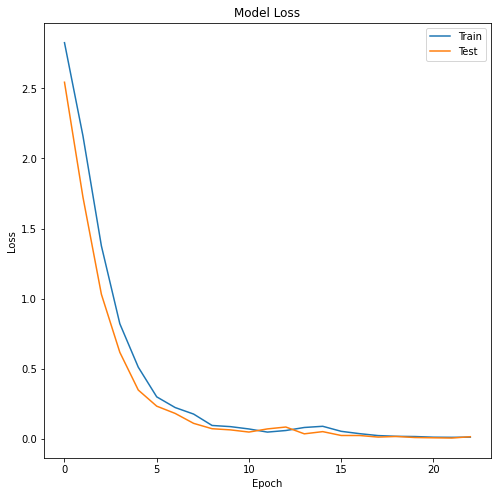

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_14.evaluate(test_generator)


25/25 [==============================] - 28s 1s/step - loss: 0.0163 - accuracy: 0.9961


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.016301536932587624
Accuracy: 0.9961414933204651


# Model_15: 2 conv layer with Batch Normalization

In [ ]:
model_15 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    BatchNormalization(), # batch normalization
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_15.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 flatten (Flatten)           (None, 16928)             0

## Compile the model

In [ ]:
model_15.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_15.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_15.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_15 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 881s 60s/step - loss: 2.2413 - accuracy: 0.3875 - val_loss: 2.6152 - val_accuracy: 0.1262
Epoch 2/200
15/15 [==============================] - 306s 21s/step - loss: 1.4168 - accuracy: 0.7354 - val_loss: 2.2960 - val_accuracy: 0.5707
Epoch 3/200
15/15 [==============================] - 176s 12s/step - loss: 0.9822 - accuracy: 0.8901 - val_loss: 2.1211 - val_accuracy: 0.8090
Epoch 4/200
15/15 [==============================] - 122s 8s/step - loss: 0.7183 - accuracy: 0.9383 - val_loss: 2.0819 - val_accuracy: 0.9395
Epoch 5/200
15/15 [==============================] - 92s 6s/step - loss: 0.5265 - accuracy: 0.9802 - val_loss: 1.8385 - val_accuracy: 0.9613
Epoch 6/200
15/15 [==============================] - 66s 5s/step - loss: 0.4007 - accuracy: 0.9917 - val_loss: 1.7553 - val_accuracy: 0.9812
Epoch 7/200
15/15 [==============================] - 55s 4s/step - loss: 0.3359 - accuracy: 0.9922 - val_loss: 1.5315 - val_accuracy: 0.9949
Epoch 

## Evaluation

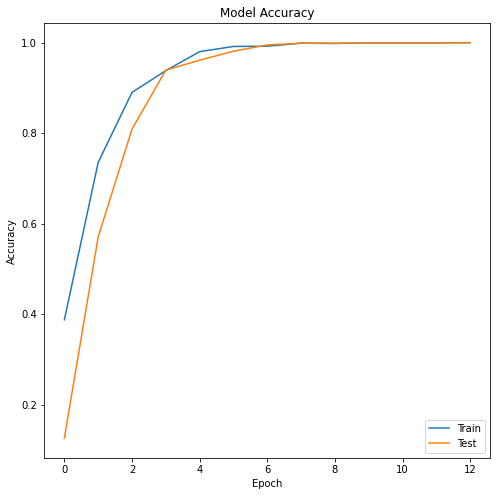

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

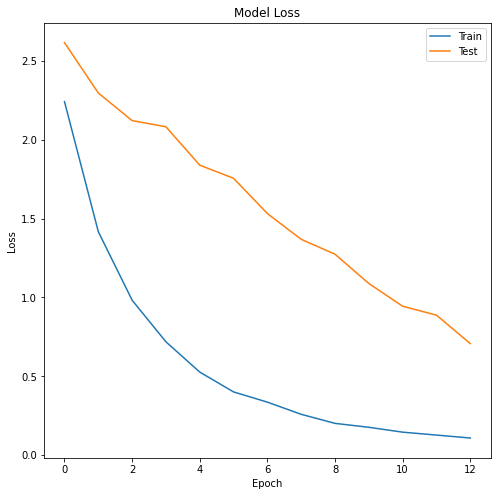

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_15.evaluate(test_generator)


25/25 [==============================] - 16s 659ms/step - loss: 0.7057 - accuracy: 1.0000


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.7057221531867981
Accuracy: 1.0


# Model_16: 2 conv layer All changes

In [ ]:
model_16 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'), # using padding
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    BatchNormalization(), # batch normalization
    keras.layers.Dense(num_classes,  activation='softmax',kernel_regularizer=tf.keras.regularizers.L2(0.001)) # regularization
])

model_16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 50, 50, 16)        1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 32)        12832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 32)          0         
                                                                 
 flatten_2 (Flatten)         (None, 1152)             

## Compile the model

In [ ]:
model_16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_16.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_16.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_16 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 27s 2s/step - loss: 3.0550 - accuracy: 0.1373 - val_loss: 3.1156 - val_accuracy: 0.1449
Epoch 2/200
15/15 [==============================] - 24s 2s/step - loss: 2.4353 - accuracy: 0.3750 - val_loss: 3.0311 - val_accuracy: 0.2961
Epoch 3/200
15/15 [==============================] - 23s 2s/step - loss: 1.9548 - accuracy: 0.5885 - val_loss: 2.9217 - val_accuracy: 0.4305
Epoch 4/200
15/15 [==============================] - 24s 2s/step - loss: 1.5837 - accuracy: 0.6876 - val_loss: 2.7813 - val_accuracy: 0.6719
Epoch 5/200
15/15 [==============================] - 23s 2s/step - loss: 1.2709 - accuracy: 0.8015 - val_loss: 2.6729 - val_accuracy: 0.8148
Epoch 6/200
15/15 [==============================] - 24s 2s/step - loss: 1.0434 - accuracy: 0.8739 - val_loss: 2.5246 - val_accuracy: 0.8152
Epoch 7/200
15/15 [==============================] - 24s 2s/step - loss: 0.8504 - accuracy: 0.9133 - val_loss: 2.3733 - val_accuracy: 0.9457
Epoch 8/200
1

## Evaluation

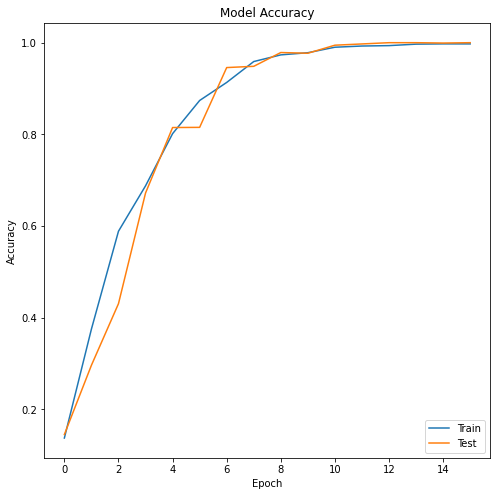

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

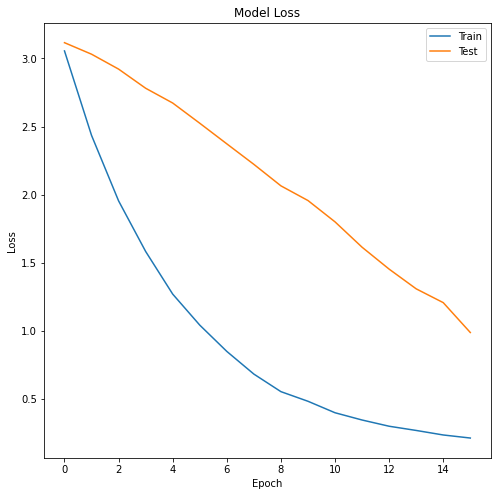

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_16.evaluate(test_generator)


25/25 [==============================] - 15s 612ms/step - loss: 0.9889 - accuracy: 1.0000


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.9889497756958008
Accuracy: 1.0


# Model_17: 3 conv layer of Basemodel

In [ ]:
model_17 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    # 1st Conv Layer
    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 2nd Conv Layer
    keras.layers.Conv2D(32, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 3rd Conv Layer
    keras.layers.Conv2D(64, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_17.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)      

## Compile the model

In [ ]:
model_17.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_17.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_17.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_17 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 30s 2s/step - loss: 3.0577 - accuracy: 0.1016 - val_loss: 2.7935 - val_accuracy: 0.2430
Epoch 2/200
15/15 [==============================] - 28s 2s/step - loss: 2.3829 - accuracy: 0.3109 - val_loss: 1.7745 - val_accuracy: 0.4379
Epoch 3/200
15/15 [==============================] - 28s 2s/step - loss: 1.5158 - accuracy: 0.5396 - val_loss: 1.0329 - val_accuracy: 0.7273
Epoch 4/200
15/15 [==============================] - 27s 2s/step - loss: 0.9510 - accuracy: 0.7115 - val_loss: 0.6966 - val_accuracy: 0.7922
Epoch 5/200
15/15 [==============================] - 26s 2s/step - loss: 0.6610 - accuracy: 0.7901 - val_loss: 0.4358 - val_accuracy: 0.8574
Epoch 6/200
15/15 [==============================] - 27s 2s/step - loss: 0.4642 - accuracy: 0.8427 - val_loss: 0.3029 - val_accuracy: 0.9035
Epoch 7/200
15/15 [==============================] - 25s 2s/step - loss: 0.3292 - accuracy: 0.8872 - val_loss: 0.2075 - val_accuracy: 0.9477
Epoch 8/200
1

## Evaluation

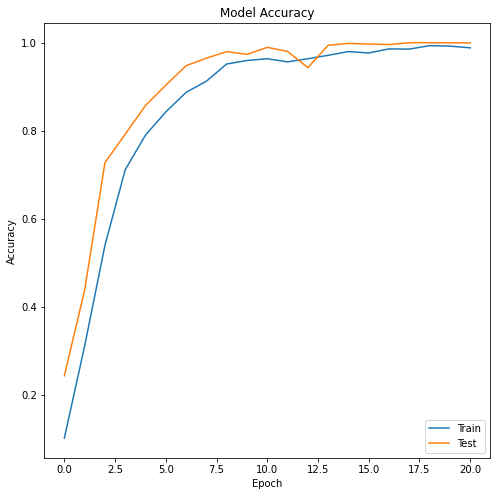

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

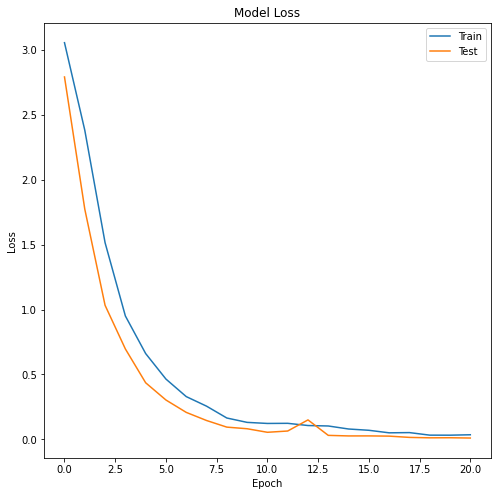

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_17.evaluate(test_generator)


25/25 [==============================] - 18s 733ms/step - loss: 0.0098 - accuracy: 0.9997


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.00979670975357294
Accuracy: 0.9996784329414368


# Model_18: 3 conv layer with Padding

In [ ]:
model_18 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    # 1st Conv Layer
    keras.layers.Conv2D(16, 3, padding='Same', activation='relu'), # 'Same' uses padding
    keras.layers.MaxPooling2D(2),
    # 2nd Conv Layer
    keras.layers.Conv2D(32, 3, padding='Same', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 3rd Conv Layer
    keras.layers.Conv2D(64, 3, padding='Same', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_18.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 64)      

## Compile the model

In [ ]:
model_18.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_18.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_18.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_18 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 28s 2s/step - loss: 2.9986 - accuracy: 0.1166 - val_loss: 2.7235 - val_accuracy: 0.1344
Epoch 2/200
15/15 [==============================] - 26s 2s/step - loss: 2.4057 - accuracy: 0.2625 - val_loss: 1.9786 - val_accuracy: 0.3566
Epoch 3/200
15/15 [==============================] - 26s 2s/step - loss: 1.6215 - accuracy: 0.4870 - val_loss: 1.1484 - val_accuracy: 0.6336
Epoch 4/200
15/15 [==============================] - 26s 2s/step - loss: 0.9946 - accuracy: 0.6807 - val_loss: 0.7338 - val_accuracy: 0.7977
Epoch 5/200
15/15 [==============================] - 26s 2s/step - loss: 0.6020 - accuracy: 0.8167 - val_loss: 0.4325 - val_accuracy: 0.8785
Epoch 6/200
15/15 [==============================] - 25s 2s/step - loss: 0.3668 - accuracy: 0.8844 - val_loss: 0.3323 - val_accuracy: 0.8855
Epoch 7/200
15/15 [==============================] - 26s 2s/step - loss: 0.3154 - accuracy: 0.9010 - val_loss: 0.1505 - val_accuracy: 0.9652
Epoch 8/200
1

## Evaluation

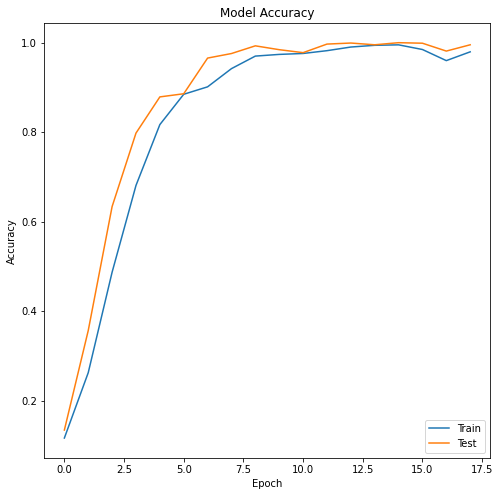

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

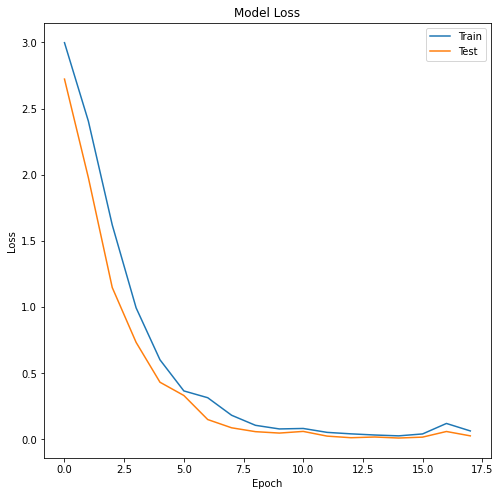

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_18.evaluate(test_generator)


25/25 [==============================] - 18s 716ms/step - loss: 0.0258 - accuracy: 0.9955


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.025758663192391396
Accuracy: 0.9954984188079834


# Model_19: 3 conv layer with Regularization

In [ ]:
model_19 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    # 1st Conv Layer
    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 2nd Conv Layer
    keras.layers.Conv2D(32, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 3rd Conv Layer
    keras.layers.Conv2D(64, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax',kernel_regularizer=tf.keras.regularizers.L2(0.001))
]) # Using Regularization

model_19.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 64)      

## Compile the model

In [ ]:
model_19.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_19.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_19.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_19 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 28s 2s/step - loss: 3.0939 - accuracy: 0.0857 - val_loss: 2.8584 - val_accuracy: 0.1027
Epoch 2/200
15/15 [==============================] - 26s 2s/step - loss: 2.5175 - accuracy: 0.2257 - val_loss: 2.1134 - val_accuracy: 0.3672
Epoch 3/200
15/15 [==============================] - 26s 2s/step - loss: 1.8148 - accuracy: 0.4615 - val_loss: 1.4810 - val_accuracy: 0.5758
Epoch 4/200
15/15 [==============================] - 26s 2s/step - loss: 1.2562 - accuracy: 0.6211 - val_loss: 0.9462 - val_accuracy: 0.7246
Epoch 5/200
15/15 [==============================] - 26s 2s/step - loss: 0.8949 - accuracy: 0.7156 - val_loss: 0.6714 - val_accuracy: 0.7914
Epoch 6/200
15/15 [==============================] - 28s 2s/step - loss: 0.6603 - accuracy: 0.8005 - val_loss: 0.4733 - val_accuracy: 0.8641
Epoch 7/200
15/15 [==============================] - 26s 2s/step - loss: 0.4969 - accuracy: 0.8484 - val_loss: 0.3359 - val_accuracy: 0.9156
Epoch 8/200
1

## Evaluation

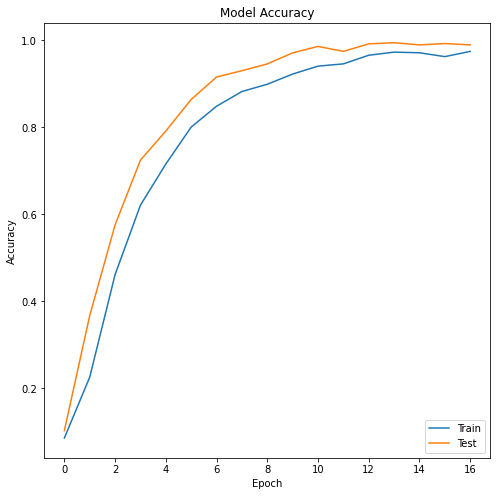

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

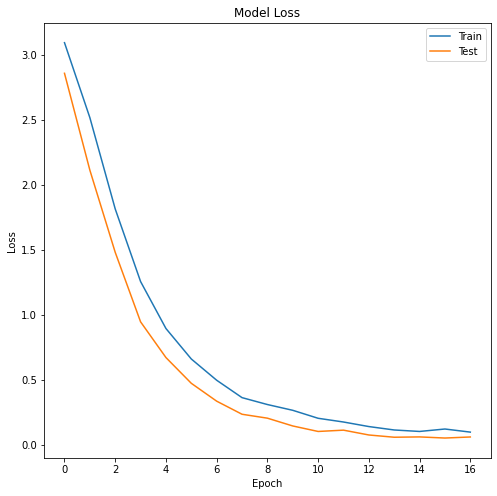

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_19.evaluate(test_generator)


25/25 [==============================] - 17s 697ms/step - loss: 0.0625 - accuracy: 0.9884


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.06253731995820999
Accuracy: 0.9884244203567505


# Model_20: 3 conv layer Kernel size (5,5)

In [ ]:
model_20 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    # 1st Conv Layer
    keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 2nd Conv Layer
    keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 3rd Conv Layer
    keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_20.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 44, 44, 32)        12832     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 18, 64)        51264     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 9, 9, 64)        

## Compile the model

In [ ]:
model_20.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_20.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_20.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_20 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 30s 2s/step - loss: 3.0019 - accuracy: 0.1063 - val_loss: 2.6432 - val_accuracy: 0.1840
Epoch 2/200
15/15 [==============================] - 26s 2s/step - loss: 2.2222 - accuracy: 0.3464 - val_loss: 1.6599 - val_accuracy: 0.4758
Epoch 3/200
15/15 [==============================] - 26s 2s/step - loss: 1.3847 - accuracy: 0.5635 - val_loss: 0.8378 - val_accuracy: 0.7113
Epoch 4/200
15/15 [==============================] - 26s 2s/step - loss: 0.8568 - accuracy: 0.7057 - val_loss: 0.5625 - val_accuracy: 0.8207
Epoch 5/200
15/15 [==============================] - 26s 2s/step - loss: 0.5449 - accuracy: 0.8094 - val_loss: 0.2554 - val_accuracy: 0.9320
Epoch 6/200
15/15 [==============================] - 26s 2s/step - loss: 0.4399 - accuracy: 0.8409 - val_loss: 0.2182 - val_accuracy: 0.9316
Epoch 7/200
15/15 [==============================] - 27s 2s/step - loss: 0.2176 - accuracy: 0.9286 - val_loss: 0.0970 - val_accuracy: 0.9730
Epoch 8/200
1

## Evaluation

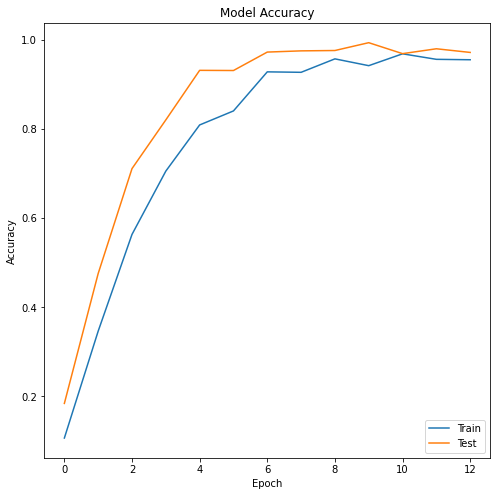

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

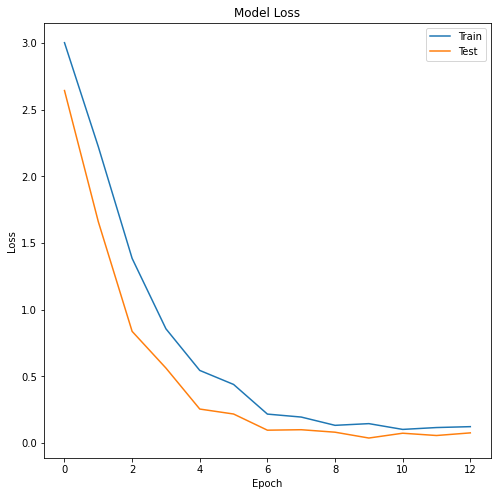

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_20.evaluate(test_generator)


25/25 [==============================] - 16s 648ms/step - loss: 0.0762 - accuracy: 0.9733


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.0762052834033966
Accuracy: 0.9733119010925293


# Model_21: 3 conv layer with Stides(2,2)

In [ ]:
model_21 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    # 1st Conv Layer
    keras.layers.Conv2D(16, 3, strides=(2, 2),padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 2nd Conv Layer
    keras.layers.Conv2D(32, 3, strides=(2, 2), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 3rd Conv Layer
    keras.layers.Conv2D(64, 3, strides=(2, 2), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_21.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 49, 49, 16)        448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 1, 1, 64)        

## Compile the model

In [ ]:
model_21.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_21.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_21.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_21 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 27s 2s/step - loss: 3.1658 - accuracy: 0.0490 - val_loss: 3.1473 - val_accuracy: 0.0500
Epoch 2/200
15/15 [==============================] - 25s 2s/step - loss: 3.1356 - accuracy: 0.0692 - val_loss: 3.1003 - val_accuracy: 0.0699
Epoch 3/200
15/15 [==============================] - 24s 2s/step - loss: 3.0744 - accuracy: 0.0969 - val_loss: 2.9784 - val_accuracy: 0.1297
Epoch 4/200
15/15 [==============================] - 24s 2s/step - loss: 2.9518 - accuracy: 0.1112 - val_loss: 2.8047 - val_accuracy: 0.1281
Epoch 5/200
15/15 [==============================] - 25s 2s/step - loss: 2.7635 - accuracy: 0.1344 - val_loss: 2.5253 - val_accuracy: 0.1813
Epoch 6/200
15/15 [==============================] - 25s 2s/step - loss: 2.5677 - accuracy: 0.1607 - val_loss: 2.2985 - val_accuracy: 0.2152
Epoch 7/200
15/15 [==============================] - 25s 2s/step - loss: 2.3866 - accuracy: 0.1937 - val_loss: 2.0655 - val_accuracy: 0.3480
Epoch 8/200
1

## Evaluation

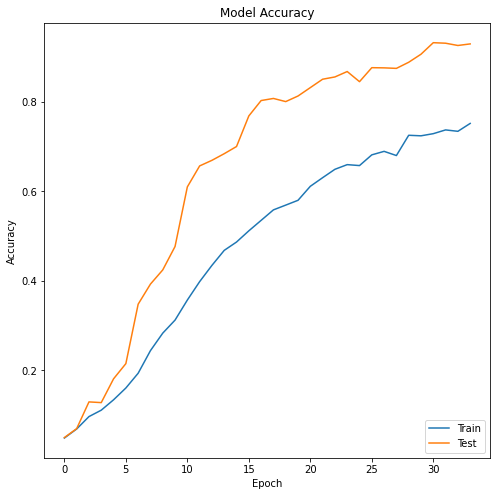

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

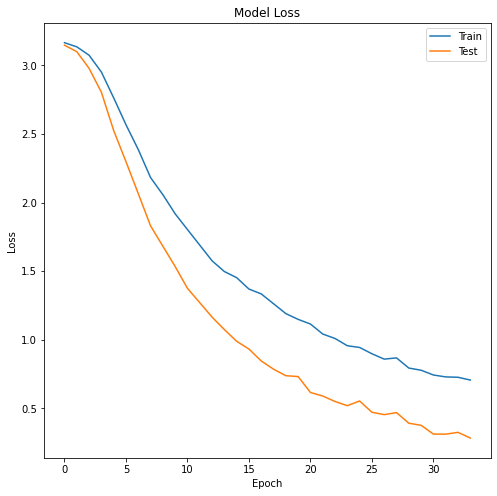

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_21.evaluate(test_generator)


25/25 [==============================] - 17s 683ms/step - loss: 0.2808 - accuracy: 0.9322


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.28078341484069824
Accuracy: 0.9321543574333191


# Model_22: 3 conv layer Dropout rate = 0.3

In [ ]:
model_22 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    # 1st Conv Layer
    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 2nd Conv Layer
    keras.layers.Conv2D(32, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 3rd Conv Layer
    keras.layers.Conv2D(64, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_22.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

## Compile the model

In [ ]:
model_22.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_22.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_22.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_22 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 1138s 78s/step - loss: 3.0601 - accuracy: 0.1112 - val_loss: 2.9035 - val_accuracy: 0.1492
Epoch 2/200
15/15 [==============================] - 555s 37s/step - loss: 2.6817 - accuracy: 0.2281 - val_loss: 2.3890 - val_accuracy: 0.2945
Epoch 3/200
15/15 [==============================] - 396s 27s/step - loss: 2.1694 - accuracy: 0.3552 - val_loss: 1.9248 - val_accuracy: 0.4199
Epoch 4/200
15/15 [==============================] - 262s 17s/step - loss: 1.7211 - accuracy: 0.4755 - val_loss: 1.3690 - val_accuracy: 0.6117
Epoch 5/200
15/15 [==============================] - 175s 12s/step - loss: 1.2411 - accuracy: 0.5995 - val_loss: 0.9902 - val_accuracy: 0.6723
Epoch 6/200
15/15 [==============================] - 131s 9s/step - loss: 0.8863 - accuracy: 0.7078 - val_loss: 0.6458 - val_accuracy: 0.7910
Epoch 7/200
15/15 [==============================] - 91s 6s/step - loss: 0.5571 - accuracy: 0.8156 - val_loss: 0.4256 - val_accuracy: 0.8613
E

## Evaluation

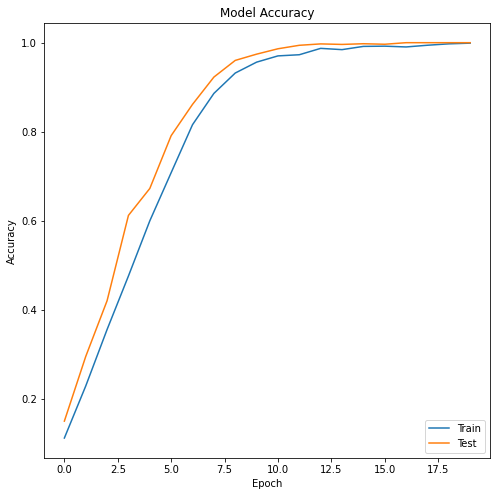

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

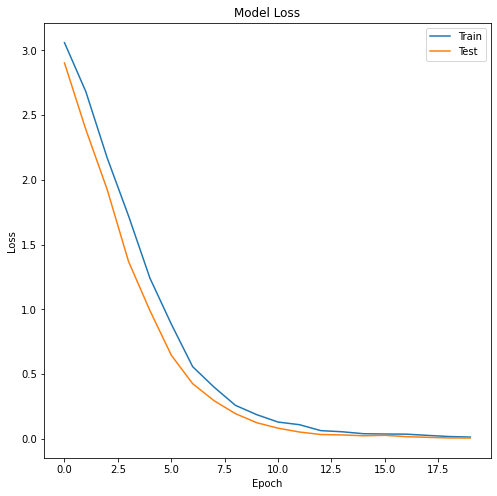

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_22.evaluate(test_generator)


25/25 [==============================] - 15s 609ms/step - loss: 0.0057 - accuracy: 1.0000


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.005687730852514505
Accuracy: 1.0


# Model_23: 3 conv layer with Batch Normalization

In [ ]:
model_23 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    # 1st Conv Layer
    keras.layers.Conv2D(16, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 2nd Conv Layer
    keras.layers.Conv2D(32, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    # 3rd Conv Layer
    keras.layers.Conv2D(64, 3, padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    BatchNormalization(), # batch normalization
    keras.layers.Dense(num_classes,  activation='softmax')
])

model_23.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)      

## Compile the model

In [ ]:
model_23.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_23.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_23.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_23 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 25s 2s/step - loss: 2.7754 - accuracy: 0.1916 - val_loss: 2.8531 - val_accuracy: 0.1641
Epoch 2/200
15/15 [==============================] - 23s 2s/step - loss: 2.0393 - accuracy: 0.4933 - val_loss: 2.7205 - val_accuracy: 0.4066
Epoch 3/200
15/15 [==============================] - 23s 2s/step - loss: 1.6071 - accuracy: 0.6750 - val_loss: 2.6227 - val_accuracy: 0.6375
Epoch 4/200
15/15 [==============================] - 23s 2s/step - loss: 1.2320 - accuracy: 0.8443 - val_loss: 2.4728 - val_accuracy: 0.8480
Epoch 5/200
15/15 [==============================] - 23s 2s/step - loss: 0.9628 - accuracy: 0.9177 - val_loss: 2.2618 - val_accuracy: 0.9480
Epoch 6/200
15/15 [==============================] - 23s 2s/step - loss: 0.7500 - accuracy: 0.9462 - val_loss: 2.0712 - val_accuracy: 0.9629
Epoch 7/200
15/15 [==============================] - 24s 2s/step - loss: 0.6116 - accuracy: 0.9707 - val_loss: 1.9447 - val_accuracy: 0.9855
Epoch 8/200
1

## Evaluation

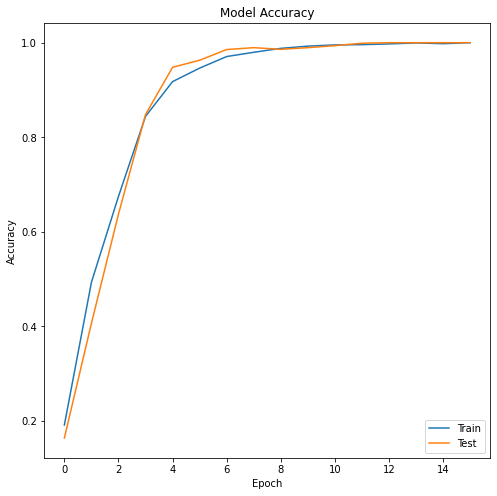

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

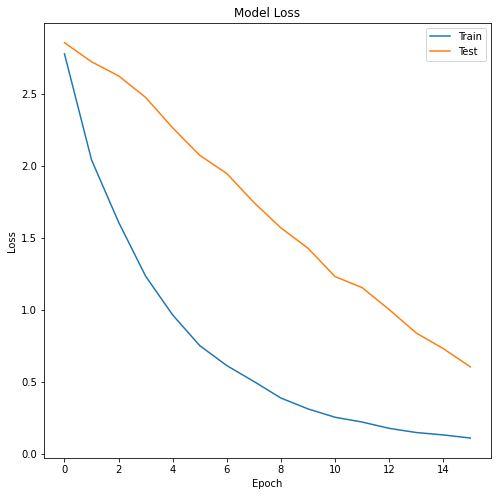

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_23.evaluate(test_generator)


25/25 [==============================] - 16s 617ms/step - loss: 0.6058 - accuracy: 1.0000


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.6057559251785278
Accuracy: 1.0


# Model_24: 3 conv layer All Changes

In [ ]:
model_24 = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),

    keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'), # using padding
    keras.layers.MaxPooling2D(2),
      # 2nd layer
    keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'),
        # 3rd Conv Layer
    keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.MaxPooling2D(2),
     keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    BatchNormalization(), # batch normalization
    keras.layers.Dense(num_classes,  activation='softmax',kernel_regularizer=tf.keras.regularizers.L2(0.001)) # regularization
])

model_24.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        12832     
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 64)        

## Compile the model

In [ ]:
model_24.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the Model

In [ ]:
start_time = dt.now()
history = model_24.fit(
  train_generator,
  epochs=200,
  verbose=1,
  steps_per_epoch=15,
  validation_steps=20,
  validation_data=test_generator,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint("model_24.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),]
)
end_time = dt.now()
print(f'Model_24 fit time: {end_time-start_time}')

Epoch 1/200
15/15 [==============================] - 1733s 122s/step - loss: 3.1599 - accuracy: 0.0802 - val_loss: 3.1656 - val_accuracy: 0.0758
Epoch 2/200
15/15 [==============================] - 550s 38s/step - loss: 2.8089 - accuracy: 0.1750 - val_loss: 3.1268 - val_accuracy: 0.0773
Epoch 3/200
15/15 [==============================] - 271s 18s/step - loss: 2.4994 - accuracy: 0.3203 - val_loss: 3.0646 - val_accuracy: 0.2367
Epoch 4/200
15/15 [==============================] - 168s 11s/step - loss: 2.1730 - accuracy: 0.4412 - val_loss: 2.9941 - val_accuracy: 0.4426
Epoch 5/200
15/15 [==============================] - 132s 9s/step - loss: 1.8677 - accuracy: 0.5698 - val_loss: 2.9213 - val_accuracy: 0.6227
Epoch 6/200
15/15 [==============================] - 98s 6s/step - loss: 1.6197 - accuracy: 0.6714 - val_loss: 2.8214 - val_accuracy: 0.7230
Epoch 7/200
15/15 [==============================] - 68s 5s/step - loss: 1.3823 - accuracy: 0.7370 - val_loss: 2.6970 - val_accuracy: 0.7809
Ep

## Evaluation

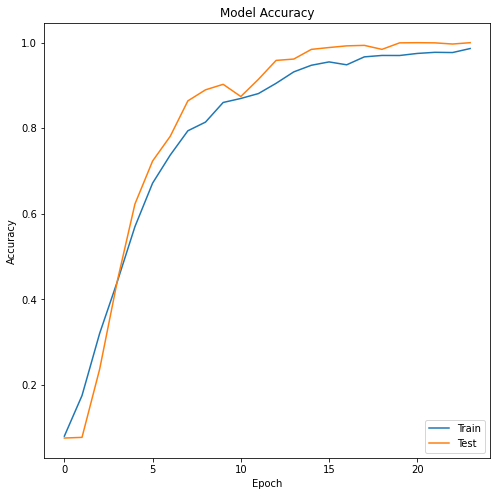

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

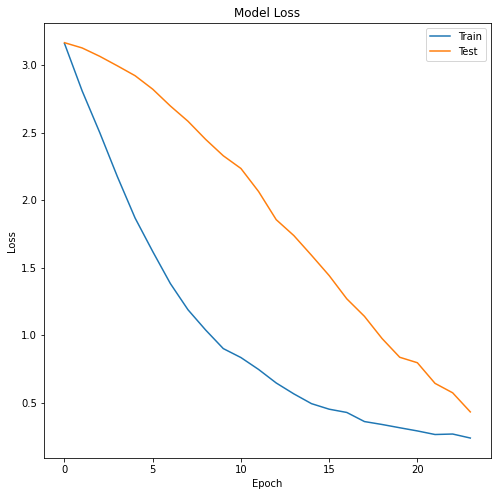

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
loss, acc = model_24.evaluate(test_generator)


25/25 [==============================] - 16s 651ms/step - loss: 0.4285 - accuracy: 0.9997


In [ ]:
print('Loss:', loss)
print('Accuracy:', acc)

Loss: 0.4285016655921936
Accuracy: 0.9996784329414368


# Extra Graphs

## Process Times

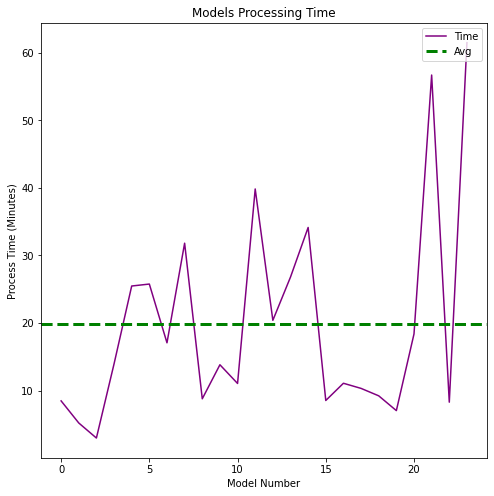

In [ ]:
# Processing time
model_times = [8.47,5.2,2.97,13.95,25.48,25.77,17.07,31.82,
               8.78,13.82,11.05,39.85,20.4,26.8,34.15,8.53,
               11.08,10.32,9.22,7.03,18.38,56.72,8.28,61.51]

plt.figure(figsize=(8,8))
plt.plot(model_times, color = 'purple')
plt.title('Models Processing Time')
plt.ylabel('Process Time (Minutes)')
plt.xlabel('Model Number')
plt.axhline(y=np.nanmean(model_times), color='green',linestyle='--', linewidth=3, label='Average')
plt.legend(['Time','Avg'], loc='upper right')
plt.show()

## Accuracy

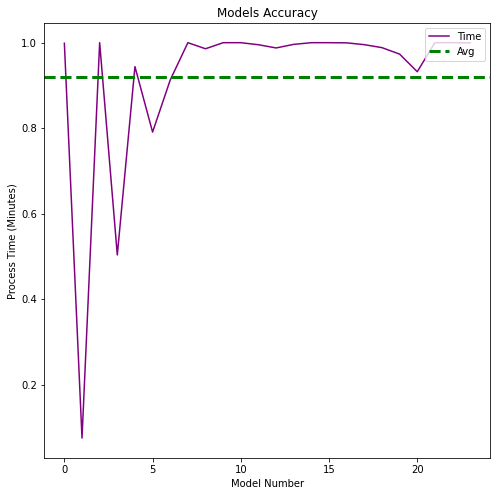

In [ ]:
acc_scores = [0.9987,0.0752,1,0.5035,0.944,0.7909,0.9128,1,
              0.9858,1,1,0.9952,0.9877,0.9961,1,1,
              0.9996,0.9954,0.9884,0.9733,0.9321,1,1,0.9996]

plt.figure(figsize=(8,8))
plt.plot(acc_scores, color = 'purple')
plt.title('Models Accuracy')
plt.ylabel('Process Time (Minutes)')
plt.xlabel('Model Number')
plt.axhline(y=np.nanmean(acc_scores), color='green',linestyle='--', linewidth=3, label='Average')
plt.legend(['Time','Avg'], loc='upper right')
plt.show()

## Loss

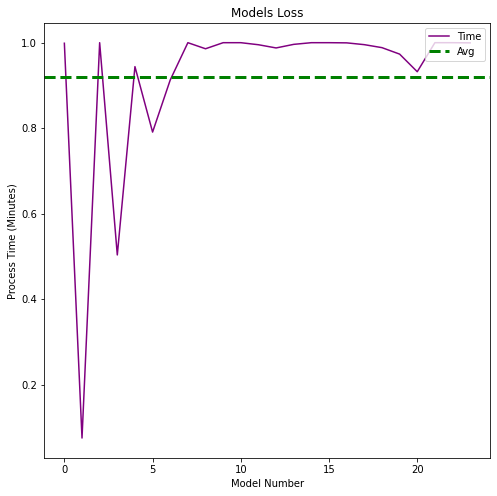

In [ ]:

loss_scores = [0.02904,3.1573,0.01533,1.4742,0.2245,0.7681,0.2761,0.6006,
               0.06069,0.0282,0.0282,0.0214,0.0673,0.0163,0.7057,0.9889,
               0.0097,0.0257,0.0625,0.0762,0.2808,0.0056,0.6057,0.4285]

plt.figure(figsize=(8,8))
plt.plot(acc_scores, color = 'purple')
plt.title('Models Loss')
plt.ylabel('Process Time (Minutes)')
plt.xlabel('Model Number')
plt.axhline(y=np.nanmean(acc_scores), color='green',linestyle='--', linewidth=3, label='Average')
plt.legend(['Time','Avg'], loc='upper right')
plt.show()